In [ ]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer

chunk_size = 40

path_ru = "../train_data/ru_train.txt"
path_en = "../train_data/en_train.txt"
path_other = "../train_data/other_train.txt"

with open(path_ru, encoding='utf-8') as f:
    lines_ru = f.read()
all_ru_words = lines_ru.split()

samples = []
for i in range(0, len(all_ru_words), chunk_size):
    chunk = " ".join(all_ru_words[i:i + chunk_size])
    samples.append(chunk)

samples = [s for s in samples if len(s.split()) > 5] 

df_ru = pd.DataFrame(samples, columns=['text'])
df_ru['text'] = df_ru['text'].str.strip()
df_ru['lang'] = 'ru'

with open(path_other, encoding='utf-8') as f:
    lines_other = f.read()

all_other_words = lines_other.split()

samples = []
for i in range(0, len(all_other_words), chunk_size):
    chunk = " ".join(all_other_words[i:i + chunk_size])
    samples.append(chunk)

samples = [s for s in samples if len(s.split()) > 5] 

df_other = pd.DataFrame(samples, columns=['text'])
df_other['text'] = df_other['text'].str.strip()
df_other['lang'] = 'other'

with open(path_en, encoding='utf-8') as f:
    lines_en = f.read()
all_en_words = lines_en.split()

samples = []
for i in range(0, len(all_en_words), chunk_size):
    chunk = " ".join(all_en_words[i:i + chunk_size])
    samples.append(chunk)

samples = [s for s in samples if len(s.split()) > 5] 

df_en = pd.DataFrame(samples, columns=['text'])
df_en['text'] = df_en['text'].str.strip()
df_en['lang'] = 'en'

df_ru_en_other = pd.concat([df_ru, df_en, df_other], ignore_index=True)
df_final = df_ru_en_other.sample(frac=1).reset_index(drop=True)
df_final.head()

vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df_final['text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
final_tf_df = pd.concat([df_final, tfidf_df], axis=1)
final_tf_df.head()

final_tf_df['lang_code'] = final_tf_df['lang'].astype('category').cat.codes

feature_names = vectorizer.get_feature_names_out()

X = tfidf_df 
df_final['lang_code'] = df_final['lang'].astype('category').cat.codes
y = df_final['lang_code']

input_size = X.shape[1] 
print(f"Новый input_size: {input_size}")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)

Новый input_size: 5000


In [ ]:
import torch

input_size = X.shape[1] 
print(input_size)
num_of_classes = 3

class NeuroLangProcessor(torch.nn.Module):
    def __init__(self, input_size: int, classes: int):
        super().__init__()
        self.layer_1 = torch.nn.Linear(in_features=input_size, out_features=256)
        self.hidden = torch.nn.ReLU()
        self.layer_2 = torch.nn.Linear(in_features=256, out_features=classes)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.hidden(out)
        out = self.layer_2(out)
        return out
    
neuro = NeuroLangProcessor(input_size=input_size, classes=num_of_classes)
X_train_tensor = torch.tensor(X_train.astype(float).to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.astype(float).to_numpy(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

predictions = neuro(X_train_tensor)

print("Предсказания для первых 5 примеров:")
print(predictions[:5])

5000
Предсказания для первых 5 примеров:
tensor([[ 0.0335, -0.0288,  0.0351],
        [ 0.0392, -0.0305,  0.0363],
        [ 0.0372, -0.0301,  0.0325],
        [ 0.0414, -0.0312,  0.0346],
        [ 0.0347, -0.0262,  0.0406]], grad_fn=<SliceBackward0>)


In [3]:
def accurancy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=neuro.parameters(), lr=0.001, weight_decay=1e-4)

def learn_binary_classificator(model, n_epochs, loss_fn, opt):
    torch.manual_seed(42)
    for epoch in range(n_epochs):
        model.train() 

        y_logits = model(X_train_tensor).squeeze()
        y_pred_labels = torch.argmax(y_logits, dim=1)

        loss = loss_fn(y_logits, y_train_tensor.long()) 
        acc = accurancy(y_true=y_train_tensor, y_pred=y_pred_labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test_tensor).squeeze() 

            test_pred_labels = torch.argmax(test_logits, dim=1)
            
            test_loss = loss_fn(test_logits, y_test_tensor.long())
            test_acc = accurancy(y_true=y_test_tensor, y_pred=test_pred_labels)
        
        if epoch % 5 == 0:
             print(f"Эпоха: {epoch:3} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


learn_binary_classificator(model=neuro, n_epochs=30, loss_fn=loss_func, opt=optimizer)

Эпоха:   0 | Loss: 1.11190, Acc: 33.74% | Test loss: 1.09708, Test acc: 44.30%
Эпоха:   5 | Loss: 1.02815, Acc: 100.00% | Test loss: 1.01345, Test acc: 100.00%
Эпоха:  10 | Loss: 0.91427, Acc: 100.00% | Test loss: 0.89809, Test acc: 100.00%
Эпоха:  15 | Loss: 0.77416, Acc: 100.00% | Test loss: 0.75960, Test acc: 100.00%
Эпоха:  20 | Loss: 0.62014, Acc: 100.00% | Test loss: 0.61035, Test acc: 100.00%
Эпоха:  25 | Loss: 0.46887, Acc: 100.00% | Test loss: 0.46612, Test acc: 100.00%


In [4]:

def predict_language(text: str, model, vectorizer, labels_map: dict):
    model.eval() 
    with torch.no_grad():
    
        vectorized_text_sparse = vectorizer.transform([text.lower()]) 
        
        vectorized_text_dense = vectorized_text_sparse.toarray()
        text_tensor = torch.tensor(vectorized_text_dense, dtype=torch.float32)

        print(f"Размерность входного тензора: {text_tensor.shape}")

        logits = model(text_tensor)
        predicted_index = torch.argmax(logits, dim=1).item()
        
        reversed_labels_map = {v: k for k, v in labels_map.items()}
        
        return reversed_labels_map.get(predicted_index, "Неизвестный класс")

print("\n--- Финальное тестирование на новых строках ---")

test_sentences = [
    "This is a final test to see how the model performs on new data.", # Ожидаем 'en'
    "Это финальный тест, чтобы посмотреть, как модель справится final test to с новыми данными. ", # Ожидаем 'ru'
    "Nowe regulacje dotyczące ochrony środowiska wejdą w życie z początkiem.", # Ожидаем 'other' (польский)
    "Die Bundesregierung hat neue Maßnahmen zur Förderung erneuerbarer Energien beschlossen." # Ожидаем 'other' (немецкий)
]

lang_category = df_final['lang'].astype('category')

# Например: 'en': 0, 'other': 1, 'ru': 2
lang_map = dict(enumerate(lang_category.cat.categories))

code_to_label_map = {code: label for code, label in enumerate(lang_category.cat.categories)}

print(f"Словарь кодов для предсказания: {code_to_label_map}")

lang_map = {label: code for code, label in enumerate(lang_category.cat.categories)}

for sentence in test_sentences:
    predicted_lang = predict_language(
        text=sentence, 
        model=neuro,
        vectorizer=vectorizer,
        labels_map=lang_map
    )
    print(f"Текст: '{sentence}'\n-> Предсказано: {predicted_lang}\n")


--- Финальное тестирование на новых строках ---
Словарь кодов для предсказания: {0: 'en', 1: 'other', 2: 'ru'}
Размерность входного тензора: torch.Size([1, 5000])
Текст: 'This is a final test to see how the model performs on new data.'
-> Предсказано: en

Размерность входного тензора: torch.Size([1, 5000])
Текст: 'Это финальный тест, чтобы посмотреть, как модель справится final test to с новыми данными. '
-> Предсказано: ru

Размерность входного тензора: torch.Size([1, 5000])
Текст: 'Nowe regulacje dotyczące ochrony środowiska wejdą w życie z początkiem.'
-> Предсказано: other

Размерность входного тензора: torch.Size([1, 5000])
Текст: 'Die Bundesregierung hat neue Maßnahmen zur Förderung erneuerbarer Energien beschlossen.'
-> Предсказано: other



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_data_to_plot = X_train.to_numpy() 
y_labels_to_plot = y_train.to_numpy()

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_data_to_plot)
code_to_label_map = {
    0: 'en', 
    1: 'other', 
    2: 'ru' 
}

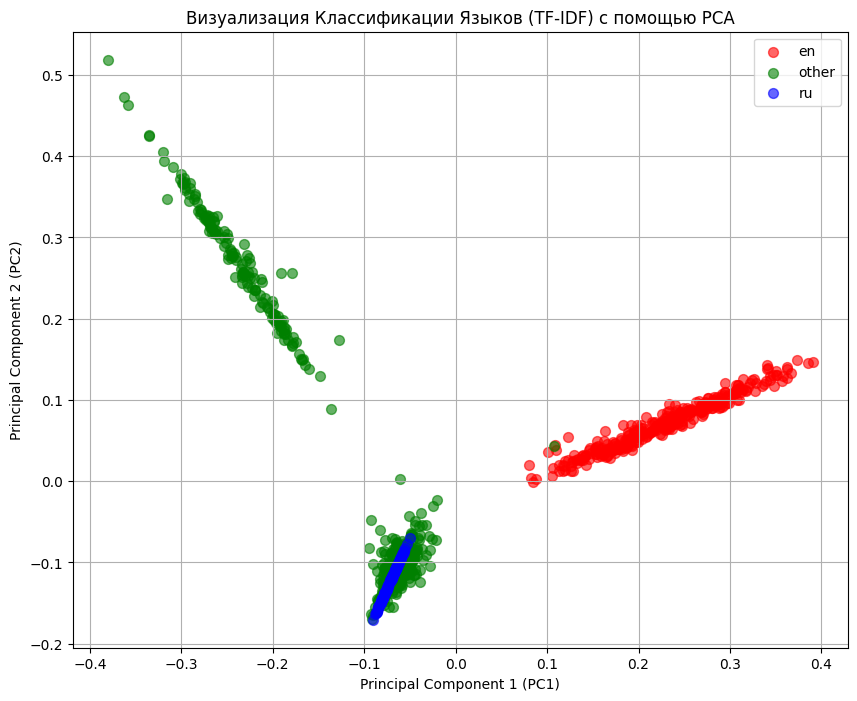

In [ ]:
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'blue']
labels = code_to_label_map.values() 

for i, label in code_to_label_map.items():
    mask = (y_labels_to_plot == i)
    
    plt.scatter(
        X_pca[mask, 0],  
        X_pca[mask, 1],  
        c=colors[i],
        label=label,
        alpha=0.6,
        s=50  
    )

plt.title('Визуализация Классификации Языков (TF-IDF) с помощью PCA')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.grid(True)
plt.show() 
#